# Importing Libraries

In [6]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import statistics as stat
from collections import Counter
import csv
import sys
import os

# Cleaning and Exploring Given Data


In [7]:
df = pd.read_csv ('routes_v3.csv')
df["ID_SA"] = df["ID_SA"].str.lower()
df["ID_DA"] = df["ID_DA"].str.lower()
df.replace(to_replace=[r"\\n","\n"], value=["",""], regex=True, inplace=True)
df.replace('',np.NaN,inplace=True)
df.dropna(subset=['ID_SA', 'ID_DA'],inplace=True)
df.to_csv('cleaned data.csv')

# Finding our Assigned Airline (AL56)

In [8]:
#AL=Airline, SA=Source Airport, DA=Destination Airport, PT=Plane Type
df_data=df[df.Code_AL=='AL56']
df_data.to_csv('Airlines for Analysis.csv',index=False)
df_data

,Code_AL,ID_AL,Code_SA,ID_SA,Code_DA,ID_DA,Codeshare,Stops,Code_PT
23062,AL56,AL56,ABJ,253,ACC,248,NaN,0,77W
23063,AL56,AL56,ACC,248,ABJ,253,NaN,0,77W
23064,AL56,AL56,ACC,248,DXB,2188,NaN,0,77W
23065,AL56,AL56,ADD,1107,DXB,2188,NaN,0,332
23066,AL56,AL56,ADL,3341,DXB,2188,NaN,0,77W
...,...,...,...,...,...,...,...,...,...
23346,AL56,AL56,WLG,2042,MEL,3339,Y,0,73H
23347,AL56,AL56,WLG,2042,SYD,3361,Y,0,73H
23348,AL56,AL56,YYZ,193,DXB,2188,NaN,0,388
23349,AL56,AL56,ZQN,2030,SYD,3361,Y,0,73H


# Extracting Input.txt File From Airline Data

In [9]:
edges = df_data[['ID_SA', 'ID_DA']].astype(int)
edges.to_csv('input.txt', sep=',', index=False,header=None)

#  Network Graph for Source and Destination Airports  

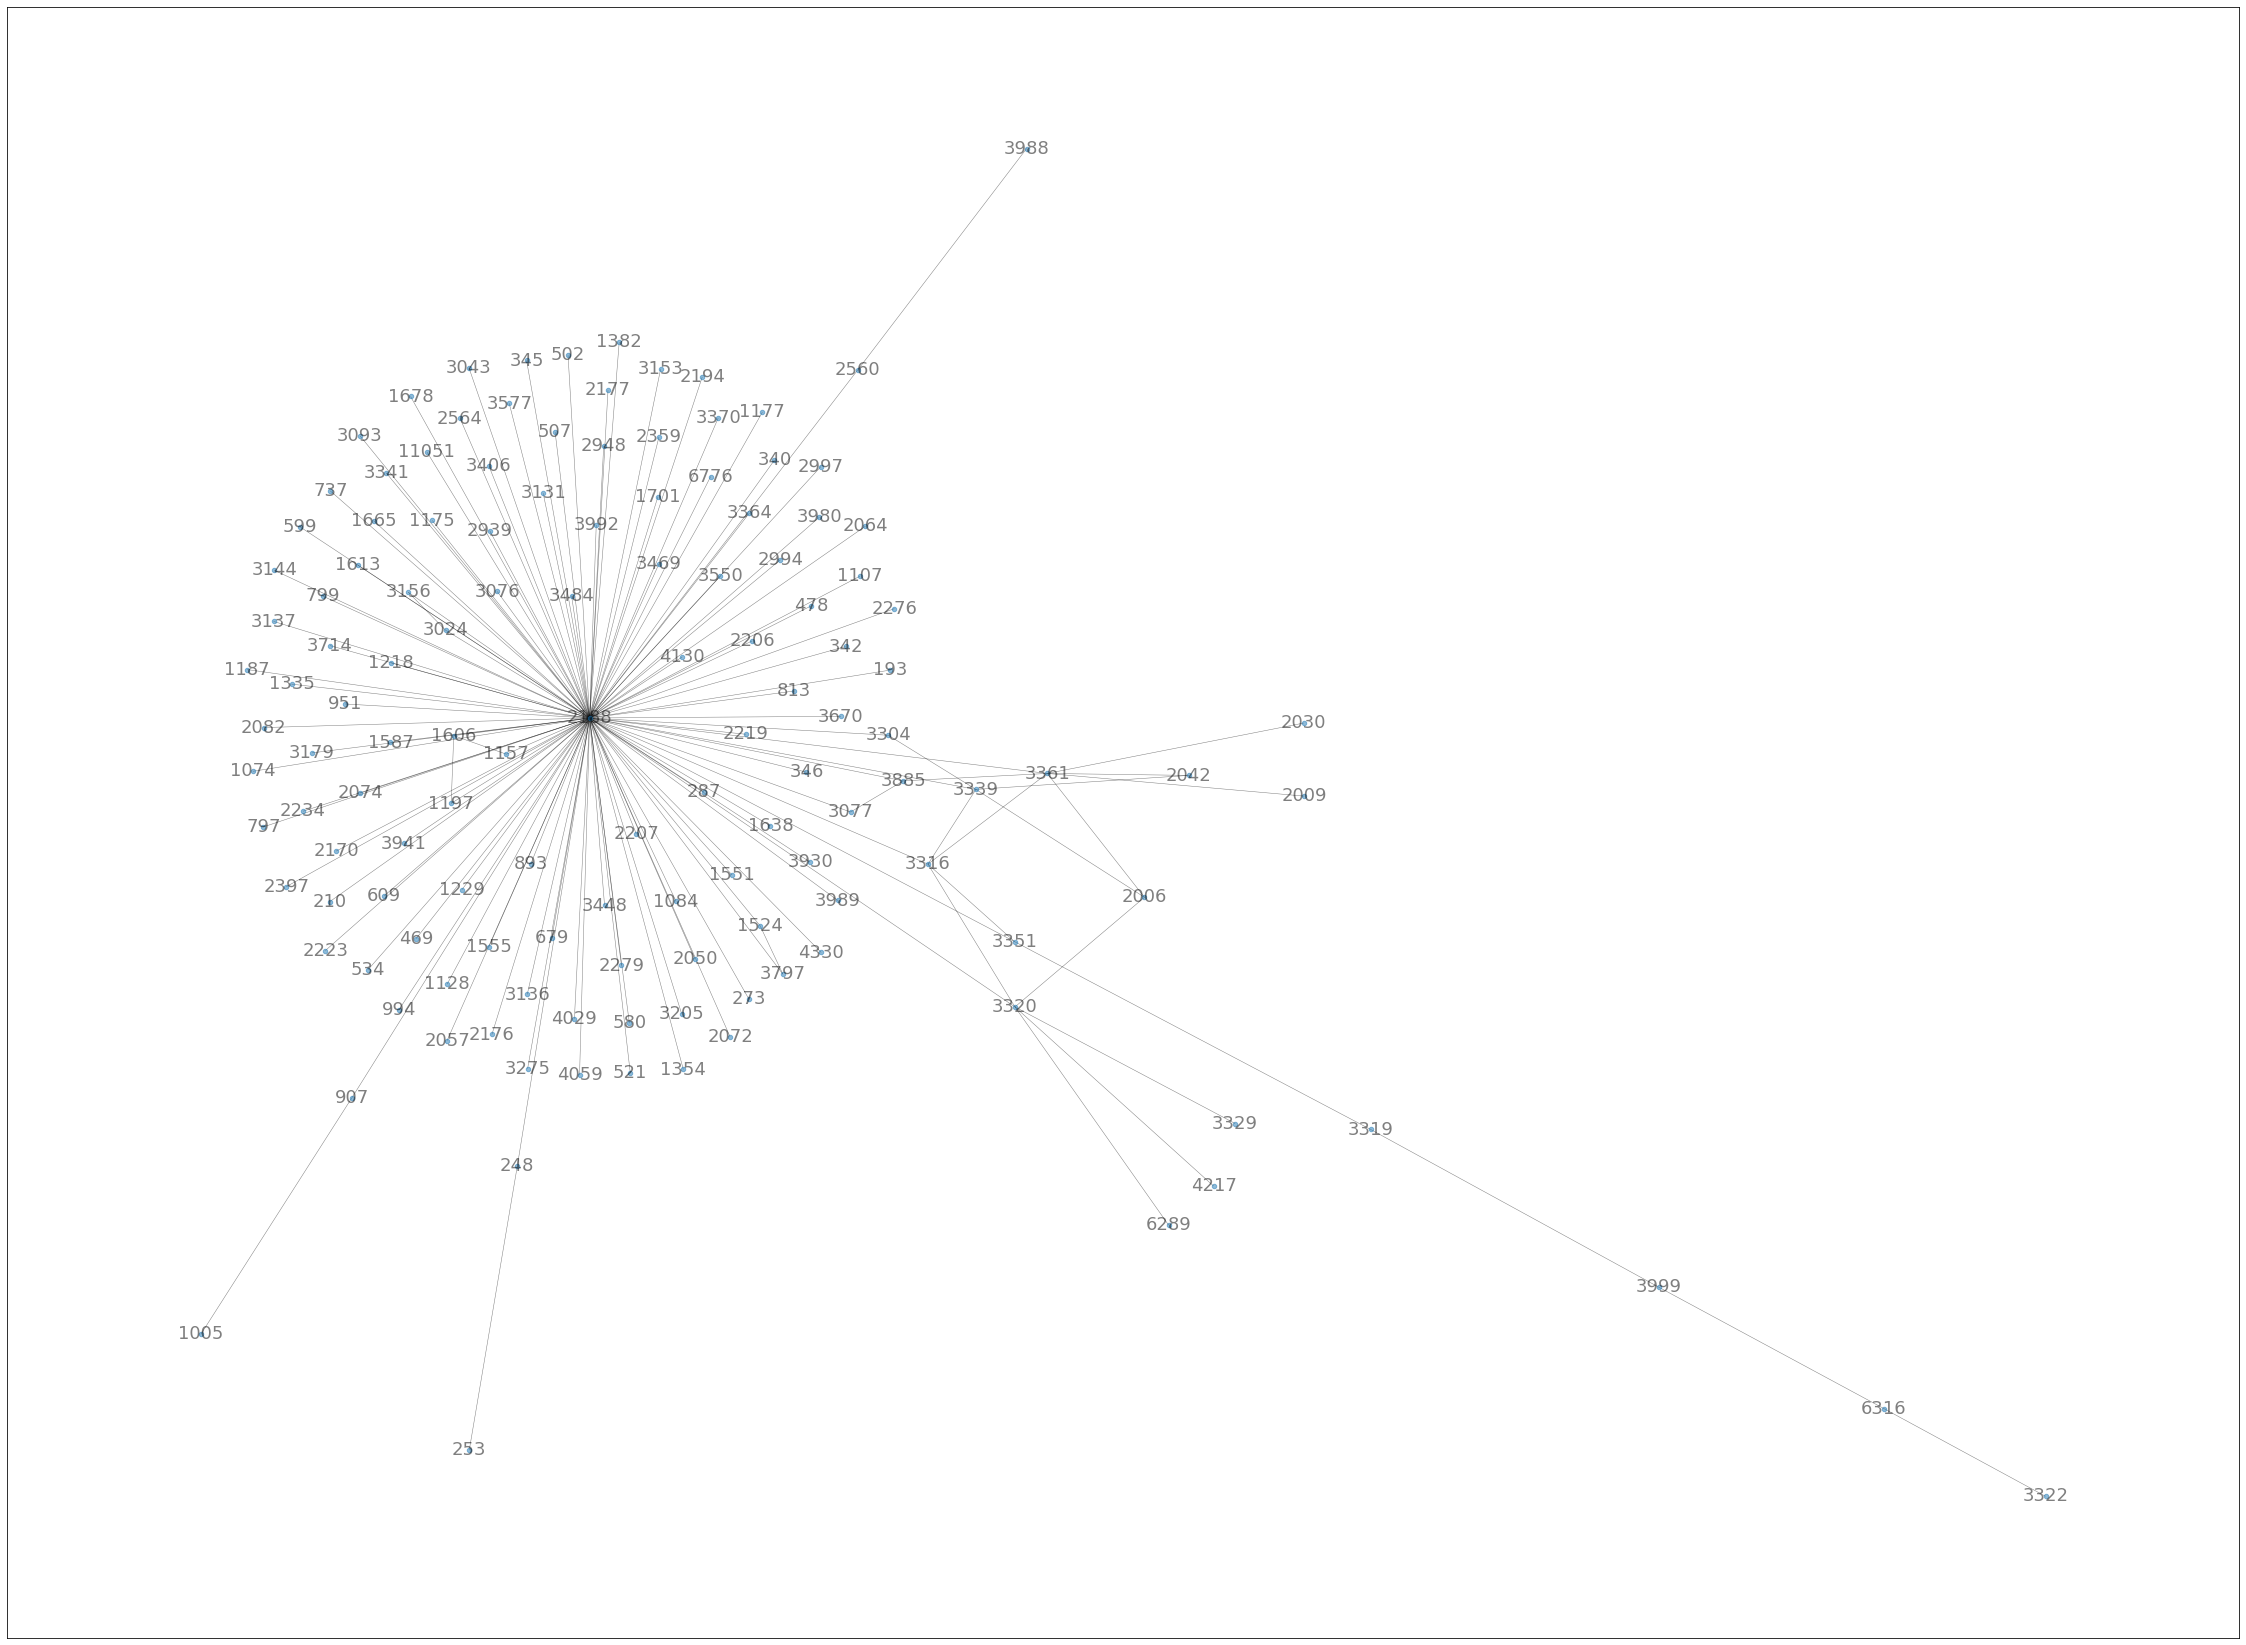

In [96]:
e= df_data[['ID_SA', 'ID_DA']].values
g = nx.from_edgelist(e)
fig, ax = plt.subplots(1, 1, figsize=(40, 30))
nx.draw_networkx(g, ax=ax, node_size=20,font_size=18, alpha=.5,width=.5)

# Extracting Characteristics of Graph and Degree Distribution Graph 

Begin Network Summary


number of nodes of layer 0 : 135
number of edges of layer 0: 148
Number of Connected Component of layer 0   :1 
Density of layer 0  : 0.01636263128800442
diameter of layer 0: 7
End network summary. Additional files are written in the same directory as the output file.


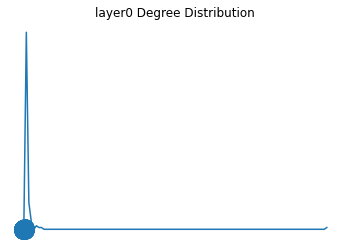

In [10]:
class MLN:
    def __init__(self):
        self.layers = []
        self.directory = os.getcwd()
    def get_all_layer(self):
        return self.layers
    def get_nth_layer(self, n):
        return self.layers[n]
    def add_layer(self, g):
        self.layers.append(g)
    def get_number_of_layers(self):
        return len(self.layers)
    def __aggregate_graph_AND(self, g1, g2):
        nodes = g1.nodes
        resultGraph = nx.Graph()
        resultGraph.add_nodes_from(nodes)
        edges_g1 = set([e for e in g1.edges])
        edges_g2 = set([e for e in g2.edges])
        common_edges = edges_g1.intersection(edges_g2)
        resultGraph.add_edges_from(common_edges)
        return resultGraph;
    def __aggregate_graph_OR(self, g1, g2):
        nodes = g1.nodes
        resultGraph = nx.Graph()
        resultGraph.add_nodes_from(nodes)
        edges_g1 = set([e for e in g1.edges])
        edges_g2 = set([e for e in g2.edges])
        output_edges = edges_g1.union(edges_g2)
        resultGraph.add_edges_from(output_edges)
        return resultGraph
    def get_aggregated_graph_AND(self):
        resultGraph = self.layers[0]
        for i in range(1, len(self.layers)):
            resultGraph = self.__aggregate_graph_AND(resultGraph, self.layers[i])
        return resultGraph;
    def get_aggregated_graph_OR(self):
        resultGraph = self.layers[0]
        for i in range(1, len(self.layers)):
            resultGraph = self.__aggregate_graph_OR(resultGraph, self.layers[i])
        return resultGraph;
def read_mln(directory_path):
    mln = MLN()
    path = directory_path
    for filename in os.listdir(path):
        if not filename.startswith('.'):
            with open(os.path.join(path, filename), 'r') as infile:
                layer = nx.Graph()
                for i, line in enumerate(infile):
                    line = line.strip('\n')
                    edgeInfo = line.split(",")
                    v1=int(edgeInfo[0])
                    v2=int(edgeInfo[1])
                    layer.add_node(v1)
                    layer.add_node(v2)
                    layer.add_edge(v1,v2)
                mln.add_layer(layer)
            infile.close()
    return mln
#used to read layers from RMAT generated format. requires the nodecount in the graph.
'''def read_PaRMAT_graphs(directory_path, nodecount):
    mln = mlnlib.MLN()
    path = directory_path
    for filename in os.listdir(path):
        if not filename.startswith('.'):
            with open(os.path.join(path, filename), 'r') as infile:
                layername = ""
                layer = nx.Graph()
                for i in range(nodecount):
                    layer.add_node(i)
                for i, line in enumerate(infile):
                    line = line.strip('\n')
                    edge = line.split("\t")
                    layer.add_edge(int(edge[0]), int(edge[1]))
                mln.add_layer(layer)
            infile.close()
    return mln'''
#writes the MLN to files. each file is created for the layers in the network.
def write_mln_to_file(mln, path):
    for i in range(0, mln.get_number_of_layers()):
        filename = "layer_" + (str(i))
        g = mln.get_nth_layer(i)
        path_to_file = os.path.join(path, filename)
        os.makedirs(os.path.dirname(path_to_file), exist_ok=True)
        with open(path_to_file, 'w') as file:
            file.write(filename)
            file.write("\n")
            file.write(str(g.number_of_nodes()))
            file.write("\n")
            file.write(str(g.number_of_edges()))
            file.write("\n")
            for i in g.nodes():
                file.write(str(i))
                file.write("\n")
            for e in g.edges:
                file.write(f"{e[0]},{e[1]},1.0")
                file.write("\n")
        file.close()
def plot_degree_histogram_v3(graph, layername, save_file_path):
    counts = Counter(d for n, d in graph.degree())
    degree_freq = [counts.get(i, 0) for i in range(max(counts) + 1)]
    #print(degree_freq)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot([k for k in range(0, len(degree_freq))], [v for v in degree_freq])
    #ax.set_yscale('log')
    #ax.set_xscale('log')
    plt.title(f"{layername} Degree Distribution")
    plt.xlabel('Degree')
    plt.ylabel('Number of nodes')
    #plt.show() # blocking function. commented out to stop interrupting the exeuction of code in batch mode.
    fig.savefig(save_file_path+"_"+layername+"_deg_dist"+".png")
def degree_statistics(graph):
    degrees = [v for k, v in graph.degree()]
    #print(degrees)
    minimum = min(degrees)
    maximum = max(degrees)
    avg = stat.mean(degrees)
    stdev = stat.stdev(degrees)
    return minimum, maximum, avg, stdev, degrees
def network_sum():
    #datasetpath = sys.argv[1]
    #output_path = sys.argv[2]
    datasetpath = './input'
    output_path = '/content/output.txt'
    #mln = read_PaRMAT_graphs(datasetpath, number_of_nodes_per_layer)
    mln = read_mln(datasetpath)
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    with open(output_path, mode='w') as analysis_file:
            fieldnames = ['number_of_nodes', 'number_of_edges', 'density',
                          'number_of_connected_comp', 'connected_comps','diameter',
                          'min_degree','max_degree', 'avg_degree','std_dev_degree']
            writer = csv.DictWriter(analysis_file, fieldnames=fieldnames)
            writer.writeheader()
    print("Begin Network Summary\n\n")
    for i in range(mln.get_number_of_layers()):
        g1 = mln.get_nth_layer(i)
        number_of_nodes = g1.number_of_nodes()
        print(f"number of nodes of layer {i} : {number_of_nodes}")
        num_of_edges = g1.number_of_edges()
        print(f"number of edges of layer {i}: {num_of_edges}")
        connected_component_g1 = [len(c) for c in sorted(nx.connected_components(g1), key=len, reverse=True)]
        print(f"Number of Connected Component of layer {i}   :{len(connected_component_g1)} ")
        density_g1 = nx.density(g1)
        print(f"Density of layer {i}  : {density_g1}")
        diameter = -1
        if len(connected_component_g1) == 1:
            diameter = nx.diameter(g1)
            print(f"diameter of layer {i}: {diameter}") #diameter is only defined in nx if the whole graph is a singel connected component.
        #print([number_of_nodes, num_of_edges, density_g1, len(connected_component_g1)])
        plot_degree_histogram_v3(g1, f"layer{i}", output_path)
        minimum_deg_g1, maximum_deg_g1, avg_deg_g1, stdev_deg_g1, degrees_g1 = degree_statistics(g1)
        with open(output_path, mode='a') as analysis_file:
            fieldnames = ['number_of_nodes', 'number_of_edges', 'density',
                          'number_of_connected_comp', 'connected_comps','diameter',
                          'min_degree','max_degree', 'avg_degree','std_dev_degree']
            writer = csv.DictWriter(analysis_file, fieldnames=fieldnames)
            writer.writerow({'number_of_nodes':number_of_nodes, 'number_of_edges':num_of_edges, 'density':density_g1,
                          'number_of_connected_comp':len(connected_component_g1), 'connected_comps':connected_component_g1,'diameter': diameter,
                          'min_degree':minimum_deg_g1,'max_degree':maximum_deg_g1, 'avg_degree':avg_deg_g1,'std_dev_degree': stdev_deg_g1})
        print("End network summary. Additional files are written in the same directory as the output file.")
        nx.draw(g1)
if __name__ == '__main__':
    network_sum()

# Determining Top Hubs for Our Airline

2188    119
3361      7
3320      6
3339      5
3316      5
3351      3
3885      3
Name: ID_SA, dtype: int64


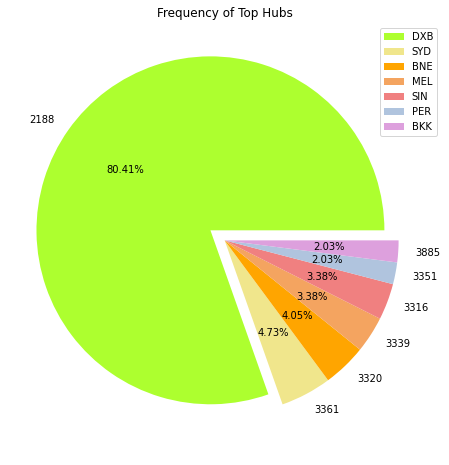

In [86]:
edges['ID_SA']=edges['ID_SA']
# Taking 7 top hubs as diameter in our graph characterstics is 7
n=7
print(edges['ID_SA'].value_counts()[:n])
# From network graph and top hubs, we have identified our airline, which is United Arab Emirates
frequency=[119,7,6,5,5,3,3]
hubs=['2188','3361','3320','3339','3316','3351','3885']
Hubs=['DXB','SYD','BNE','MEL','SIN','PER','BKK']
explode=(0.1,0,0,0,0,0,0)
colors=['greenyellow','khaki','orange','sandybrown','lightcoral','lightsteelblue','plum']
fig, axes = plt.subplots(1, 1, figsize=(16,8))
axes.pie(frequency, explode=explode, labels=hubs, colors=colors, autopct='%0.2f%%')
axes.set(title='Frequency of Top Hubs')
plt.legend(Hubs,loc='best')
plt.show()

# Population of Top Most Cities for that can be considered as next hub

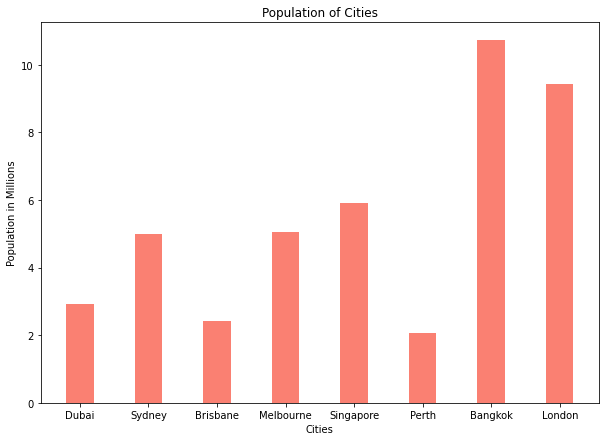

In [92]:
data = {'Dubai':2.92, 'Sydney':4.99, 'Brisbane':2.43,'Melbourne':5.06,'Singapore':5.91,'Perth':2.06,'Bangkok':10.72,'London':9.42}
Cities = list(data.keys())
Population = list(data.values())
fig = plt.figure(figsize = (10, 7))
# creating the bar plot
plt.bar(Cities, Population, color ='salmon',width = 0.4)
plt.xlabel("Cities")
plt.ylabel("Population in Millions")
plt.title("Population of Cities")
plt.show()

# Top 10 United Arab Emirates Weekly Flights

        Destinations  Flights per week
77   London Heathrow               131
38           Bangkok                87
128          Bahrain                85
34            Mumbai                82
30             Delhi                81
40           Colombo                81
50             Dhaka                79
116         New York                68
29           Chennai                67
130           Dammam                67


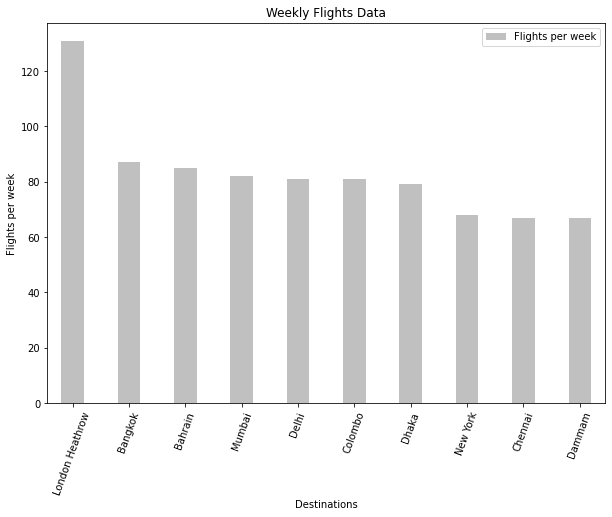

In [88]:
F=pd.read_csv('Flights.csv')
Flights=F.nlargest(10,['Flights per week'])
print(Flights)
Flights.plot.bar(x="Destinations", ylabel="Flights per week", rot=70, title="Weekly Flights Data",color='silver',width=0.4,figsize=(10,7));
plt.show();